In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My Drive/SDG

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/SDG


## Funcs

In [2]:
import gc
import psutil

def showMem():
  print(f"cuda mem after = {torch.cuda.memory_reserved()}")
  !/opt/bin/nvidia-smi
  print(dict(psutil.virtual_memory()._asdict()))

In [3]:
def cleanMemory():
  # print(f"cuda mem before = {torch.cuda.memory_reserved()}")
  # del trainer
  torch.cuda.empty_cache()
  gc.collect()
  showMem()

In [4]:
def SDGToFivePs(x):
  x = int(x.replace("_goal",""))
  if x in range(0,7):
    return 'People'
  if x in range(13,16):
    return 'Planet'
  if x in range(7,13):
    return 'Prosperity'
  if x in range(16,17):
    return 'Peace'
  if x in range(17,18):
    return 'Partnerships'
  return None

### imports

In [5]:
import pandas as pd
!pip install transformers
from transformers import BertTokenizer, BertModel, BertForMaskedLM
from transformers import AdamW
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

### plot metrics

In [6]:
def plotAccPrecRecall(y_test, y_pred, predicted_prob, verbose=False):
  accuracy = metrics.accuracy_score(y_test, y_pred)
  auc = metrics.roc_auc_score(y_test, predicted_prob, multi_class="ovr")
  print("Accuracy:",  round(accuracy,2))
  if verbose:
    print("Auc:", round(auc,2))
    print("Detail:")
    print(metrics.classification_report(y_test, y_pred))

  return accuracy

In [7]:
def plotConfusionMatrix(y_test, y_pred, labels):
  cm = metrics.confusion_matrix(y_test, y_pred, labels=labels)
  fig, ax = plt.subplots()
  sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
              cbar=False)
  ax.set(xlabel="Pred", ylabel="True", xticklabels=labels, 
        yticklabels=labels, title="Confusion matrix")
  plt.yticks(rotation=0)

In [8]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from itertools import cycle

def plotRocPrecRecallCurve(y_test, predicted_prob, labels):
  y_test_array = pd.get_dummies(y_test, drop_first=False).values
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  ## Plot roc
  for i in range(len(labels)):
      fpr[i], tpr[i], thresholds = metrics.roc_curve(y_test_array[:,i],  
                            predicted_prob[:,i])
      ax[0].plot(fpr[i], tpr[i], lw=3,
                label='{0} (area={1:0.2f})'.format(labels[i], 
                                metrics.auc(fpr[i], tpr[i]),)
                )
  # fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), predicted_prob.ravel())
  # roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(labels))]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(len(labels)):
      mean_tpr += interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= len(labels)

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  plt.figure()
  # plt.plot(fpr["micro"], tpr["micro"],
  #         label='micro-average ROC curve (area = {0:0.2f})'
  #               ''.format(roc_auc["micro"]),
  #         color='deeppink', linestyle=':', linewidth=4)

  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
          color='navy', linestyle=':', linewidth=4)

  # colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  # for i, color in zip(range(len(labels)), colors):
  #     plt.plot(fpr[i], tpr[i], color=color, lw=lw,
  #             label='ROC curve of class {0} (area = {1:0.2f})'
  #             ''.format(i, roc_auc[i]))
  
  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Some extension of Receiver operating characteristic to multi-class')
  plt.legend(loc="lower right")
  plt.show()

  ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
  ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
            xlabel='False Positive Rate', 
            ylabel="True Positive Rate (Recall)", 
            title="Receiver operating characteristic")
  ax[0].legend(loc="lower right")
  ax[0].grid(True)
      
  ## Plot precision-recall curve
  for i in range(len(labels)):
      precision, recall, thresholds = metrics.precision_recall_curve(
                  y_test_array[:,i], predicted_prob[:,i])
      ax[1].plot(recall, precision, lw=3, 
                label='{0} (area={1:0.2f})'.format(labels[i], 
                                    metrics.auc(recall, precision))
                )
  ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
            ylabel="Precision", title="Precision-Recall curve")
  ax[1].legend(loc="best")
  ax[1].grid(True)
  plt.show()

### Model

In [9]:
class SDGModel(torch.nn.Module):
  def __init__(self, output_size, device='cuda'):
    super(SDGModel, self).__init__()
    self.device = device
    self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    self.bert = BertModel.from_pretrained('bert-base-uncased', output_attentions=True)
#     for index, param in enumerate(self.bert.parameters()):
#         print(index, param.shape)
#         param.requires_grad = False
    self.out1 = torch.nn.Linear(768, 400)
    self.drop = torch.nn.Dropout(0.5)
    self.out2 = torch.nn.Linear(400, output_size)

  def forward(self, text):
    tokenized_text = self.tokenizer.tokenize("[CLS] " + text + " [SEP]")
    indexed_tokens = self.tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    if self.device == 'cuda':
      tokens_tensor = tokens_tensor.cuda()
    
    if tokens_tensor.shape[1] > 500:
      tokens_tensor = tokens_tensor[0][0:500].unsqueeze(0)
    outputs = self.bert(tokens_tensor)[0]
    o = torch.nn.ReLU()(self.out1(outputs[0][0]))
    o = self.drop(o)
    return self.out2(o)

  def getAttention(self, text):
    # tbd
    self.eval()
    inputs = self.tokenizer.encode_plus(text, return_tensors='pt', add_special_tokens=True)
    token_type_ids = inputs['token_type_ids']
    input_ids = inputs['input_ids']
    attention = self.bert(torch.tensor(input_ids).cuda(), token_type_ids=torch.tensor(token_type_ids).cuda())[-1]
    input_id_list = input_ids[0].tolist() # Batch index 0
    tokens = self.tokenizer.convert_ids_to_tokens(input_id_list)
    
    # call_html()
    # head_view(attention, tokens)
    # self.train()
    return attention, tokens

In [10]:
from sklearn import metrics
import seaborn as sns
import numpy as np

def evaluate_mode(X_test, model, labels, verbose=True):

  model.eval()
  errors = []
  softmax = torch.nn.Softmax(dim=0)

  #eval
  with torch.no_grad():
      y_pred = []
      predicted_prob = []
      y_test = X_test["Target"]
      for index, instance in X_test.iterrows():
          out = model(instance["Description"].lower())
          predicted_prob.append(softmax(out).tolist())
          y_pred.append(labels[torch.argmax(out).item()])
          # collect companies with errors
          if instance['Target'] != labels[torch.argmax(out).item()]:
            errors.append((instance['Company'], instance['Target'], labels[torch.argmax(out).item()]))
      model.train()

  predicted_prob = np.array(predicted_prob)

  ## plot Accuracy, Precision, Recall
  accuracy = plotAccPrecRecall(y_test, y_pred, predicted_prob, verbose)
      
  ## Plot confusion matrix
  plotConfusionMatrix(y_test, y_pred, labels)

  ## Plot roc, precision recall curve
  if verbose:
    plotRocPrecRecallCurve(y_test, predicted_prob, labels)

  return errors, accuracy, y_pred, predicted_prob

In [11]:
# load model from checkpoint

def loadModel(filename, dev='cuda', target=None):
  checkpoint = torch.load(f"models/"+filename, map_location=torch.device(dev))
  if target is None:
    labels = checkpoint['labels']
  elif target == 'SDG Goal':
    labels = [7, 2, 3, 12, 1, 9, 13, 4, 8, 16, 11, 6, 14, 10, 5, 15, 17]
  else:
    labels = ['Prosperity', 'People', 'Planet', 'Peace', 'Partnerships']

  device = torch.device(dev)
  model = SDGModel(len(labels))
  optimizer = AdamW(model.parameters(), lr=1e-5)

  model.load_state_dict(checkpoint['model_state_dict'])
  model.to(device)
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  # epoch = checkpoint['epoch']
  # losses = checkpoint['losses']
  # errors = checkpoint['errors']
  # accuracies = checkpoint['accuracies']

  model.eval()
  # - or -
  # model.train()

  return model

### Model Trainer

In [12]:
class ModelTrainer():
  def __init__(self, data, newModel=True, n_epochs=6, test_size=0.15, random_state=42, target_col='SDG Goal', modelFilename=None, device='cuda'):
    
    self.n_epochs = n_epochs
    self.data = data
    self.data['Target'] = self.data[target_col]
    self.labels = list(self.data['Target'].value_counts().keys().values)
    self.newModel = newModel
    self.criterion = torch.nn.CrossEntropyLoss()
    self.modelFilename = modelFilename
    self.test_size = test_size
    self.random_state = random_state
    self.target_col = target_col
    self.n_epochs = n_epochs
    self.device = device
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.data, self.data["Target"], test_size=self.test_size, random_state=self.random_state)

    
    if self.newModel:
      self.createModel()
    else:
      self.loadModel(self.modelFilename)

    self.model.train()

  def createModel(self):
    self.model = SDGModel(len(self.labels), self.device)
    self.model.to(self.device)
    self.optimizer = AdamW(self.model.parameters(), lr=1e-5)
    self.losses = []
    self.errors = []
    self.epoch = 1
    self.accuracies = []
    self.y_preds = []
    self.predicted_probs = []

  def loadModel(self, modelFilename):
    self.checkpoint = torch.load(f"models/"+modelFilename, map_location=torch.device(self.device))
    self.labels = self.checkpoint['labels']
    # labels = [7, 2, 3, 12, 1, 9, 13, 4, 8, 16, 11, 6, 14, 10, 5, 15, 17]

    device = torch.device(self.device)
    self.model = SDGModel(len(self.labels))
    self.optimizer = AdamW(self.model.parameters(), lr=1e-5)

    self.model.load_state_dict(self.checkpoint['model_state_dict'])
    self.model.to(device)
    self.optimizer.load_state_dict(self.checkpoint['optimizer_state_dict'])

    self.epoch = self.checkpoint['epoch']
    self.losses = self.checkpoint['losses']
    self.errors = self.checkpoint['errors']
    self.accuracies = self.checkpoint['accuracies']
    self.y_preds = self.checkpoint['y_preds']
    self.predicted_probs = self.checkpoint['predicted_probs']

  def train(self):
    # self.printDataValueCounts()

    start_time = time.time()

    self.epochs = self.epoch+self.n_epochs-1

    for e in range(self.epoch, self.epochs+1):
      cnt = 0
      current_loss = 0
      epoc_loss = 0;
      curr_data = self.X_train.sample(frac=1)
      print(len(curr_data))
      for index, instance in curr_data.iterrows():
        cnt += 1
        self.optimizer.zero_grad()
        out = self.model(instance["Description"].lower())
        target = torch.LongTensor([self.labels.index(instance["Target"])])
        if self.device == 'cuda':
          target = target.cuda()
        loss = self.criterion(out.view(1, -1), target)
        epoc_loss += loss
        loss.backward()
        self.optimizer.step()
        current_loss += loss.item()
        if index % 50 == 0:
          print(f"Epoch={e}, index={index}, loss={current_loss/30}, counter={cnt}")
          print(f"{instance['Target']} --> {self.labels[torch.argmax(out).item()]}")
          current_loss = 0
      error, acc, y_pred, predicted_prob = evaluate_mode(self.X_test, self.model, self.labels, False)
      print(error[0][:5])
      print(f"total loss={epoc_loss/len(curr_data)}")

      self.losses.append(epoc_loss/len(curr_data))
      self.errors.append(error)
      self.accuracies.append(acc)
      self.y_preds.append(y_pred)
      self.predicted_probs.append(predicted_prob)
      
      print(f"TIME TILL NOW: avg={(time.time() - start_time)/60/e:.1f}, for {e} epochs - {(time.time() - start_time)/60:.1f} min")


  def printDataValueCounts(self):
    print("Labels: " + str(self.labels))
    print("X_train: " + str(len(self.X_train)) + " samples")
    print("X_test: " + str(len(self.X_test)) + " samples")

    # print("X_train:")
    # print(self.X_train['Target'].value_counts())
    
    # print("X_test:")
    # print(self.X_test['Target'].value_counts())

  def getLastEval(self):
    return evaluate_mode(self.X_test, self.model, self.labels)

  def plotLosses(self):
    ## Plot loss for epoc
    %matplotlib inline
    plt.plot(range(self.epoch+self.n_epochs-1), self.losses)
    plt.ylabel('Cross Entropy Loss')
    plt.xlabel('epoch');

  def saveModel(self, filename):
    checkpoint = {
        'model_state_dict': self.model.state_dict(),
        'optimizer_state_dict': self.optimizer.state_dict(),
        'epoch': self.epochs+1,
        'losses': self.losses,
        'errors': self.errors,
        'accuracies': self.accuracies,
        'y_preds': self.y_preds,
        'predicted_probs': self.predicted_probs,
        'labels': self.labels
    }
    filename = filename.split("_checkpoint")[0]
    newFilename = f"{filename}_{checkpoint['epoch']}.tar"
    torch.save(checkpoint, f"models/{newFilename}")
    return newFilename

  def getEvalOfEpoch(self, i):
    plotAccPrecRecall(self.X_test['Target'], self.y_preds[i], self.predicted_probs[i], verbose=True)
    plotConfusionMatrix(self.X_test['Target'], self.y_preds[i], self.labels)
    plotRocPrecRecallCurve(self.X_test['Target'], self.predicted_probs[i], self.labels)



In [13]:
# # model.eval()
# # - or -
# model.train()

# Loading data

In [14]:
dataFilename = 'SDG_data_2729.csv'
# dataFilename = 'data_1_label_ai_scoop_new.csv'
# dataFilename = 'data_2652.csv'
sncFilename = 'snc100annotations.csv'

modelPsAllFilename = 'model_5Ps_all_11.tar'
modelSDGAllFilename = 'model_SDG_all_8.tar'
modelPsTopFilename = 'model_5Ps_top_7_7.tar'
modelSDGTopFilename = 'model_SDG_top_7_7.tar'

test_size=0.15
random_state=42

In [15]:
data = pd.read_csv('data/' + dataFilename)
data['SDG Goal'] = data['SDG Goal'].astype(int)
data.shape

(2729, 18)

# stats

## general

In [16]:
# Additional SDGs
data[data['Additional SDGs'].isnull() == False].shape

(133, 18)

In [17]:
# Location
data[data['Location'].isnull() == False].shape

(2493, 18)

In [18]:
# Location of Impact
data[data['Location of Impact'].isnull() == False].shape

(1781, 18)

In [19]:
# sub topics
data[(data['sub target'].isnull() == False) | (data['Rainmaking SDG Subtopic'].isnull() == False)].shape

(1751, 18)

In [20]:
# Impact Statement
data[data['Impact Statement'].isnull() == False].shape

(2160, 18)

## sdg goals and ps

In [21]:
data['SDG Goal'].value_counts()

7     719
2     375
3     259
12    235
1     222
9     167
13    142
4     102
8      85
16     78
11     64
6      58
14     55
10     51
5      46
15     36
17     35
Name: SDG Goal, dtype: int64

In [22]:
data['five Ps'].value_counts()

Prosperity      1321
People          1062
Planet           233
Peace             78
Partnerships      35
Name: five Ps, dtype: int64

## words mean + std, characters mean + std

### Pre processing

In [23]:
data['words_count'] = data['Description'].apply(lambda x: len(x.split()))
data['character_count'] = data['Description'].apply(lambda x: len(x))

In [24]:
data[data['words_count'] > 500].shape

(7, 20)

### Results

In [25]:
data.words_count.describe()

count    2729.000000
mean       81.222426
std        80.997289
min         1.000000
25%        30.000000
50%        58.000000
75%        97.000000
max       766.000000
Name: words_count, dtype: float64

In [26]:
data.character_count.describe()

count    2729.000000
mean      529.080982
std       504.831483
min         4.000000
25%       200.000000
50%       387.000000
75%       640.000000
max      4772.000000
Name: character_count, dtype: float64

## by source

In [27]:
# data['source'] = data['Source'].apply(lambda x: 'Plus impact' if x.startswith('https://plusimpact.io') else x)
data['Source'].value_counts()

Rainmaking       2187
Plus impact       424
Agora              43
Cfamedia           25
Masschallenge      21
Tech2impact        17
ZORA VC             8
Tech nation         2
ARC Impact          2
Name: Source, dtype: int64

## by country

In [28]:
data['Location'].str.lower().value_counts()[:30]

usa               471
sweden            247
denmark           209
united kingdom    137
norway            131
india             126
finland            96
netherlands        72
france             64
københavn          57
germany            53
kenya              48
spain              40
canada             36
chile              33
argentina          33
switzerland        32
australia          31
helsinki           30
israel             30
south africa       29
austria            26
mexico             24
china              20
singapore          19
ireland            16
nigeria            16
italy              16
ghana              15
helsingfors        13
Name: Location, dtype: int64

## SNC scores

### Pre processing

In [29]:
# arranging goals and ps

snc = pd.read_csv('data/'+sncFilename)
snc.shape

(100, 17)

In [30]:
snc['five Ps']

0            Prosperity
1            Prosperity
2                People
3            Prosperity
4     Prosperity,Planet
            ...        
95               People
96               People
97               People
98               Planet
99               People
Name: five Ps, Length: 100, dtype: object

In [31]:
snc['SDG Goal']

0     6,7,12
1         11
2          4
3          7
4       7,12
       ...  
95         3
96         6
97         6
98     13,14
99         6
Name: SDG Goal, Length: 100, dtype: object

#### adding Ps predictions

In [32]:
trainer = ModelTrainer(data, newModel=False, modelFilename=modelPsAllFilename)

In [33]:
# model = loadModel(modelSDGAllFilename, 'cuda', 'SDG Goal')
model = trainer.model
model.eval()

SDGModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
   

In [34]:
from torch import nn
soft = nn.Softmax(dim=0)
y_pred = []

for index, instance in snc.iterrows():
  # print(instance['name'])
  
  out = model(instance["description"].lower())
  y_pred.append(trainer.labels[torch.argmax(out).item()])

In [35]:
snc['new pred five Ps'] = pd.Series(np.array(y_pred))
snc['new pred five Ps'].value_counts()

People        73
Prosperity    26
Planet         1
Name: new pred five Ps, dtype: int64

In [36]:
# #old
# snc['new pred five Ps'] = pd.Series(np.array(y_pred))
# snc['new pred five Ps'].value_counts()

#### adding SDGs

In [37]:
print(f"cuda mem before = {torch.cuda.memory_reserved()}")
del trainer
cleanMemory()

cuda mem before = 3206545408
cuda mem after = 1138753536
Fri Nov 20 09:15:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    43W /  70W |   2149MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                   

In [38]:
trainer = ModelTrainer(data, newModel=False, modelFilename=modelSDGAllFilename)

In [39]:
modelSDGAllFilename

'model_SDG_all_8.tar'

In [40]:
# model = loadModel(modelSDGAllFilename, 'cuda', 'SDG Goal')
model = trainer.model
model.eval()

SDGModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
   

In [41]:
from torch import nn
soft = nn.Softmax(dim=0)
y_pred = []

for index, instance in snc.iterrows():
  # print(instance['name'])
  
  out = model(instance["description"].lower())
  y_pred.append(trainer.labels[torch.argmax(out).item()])

In [42]:
snc['new pred SDG'] = pd.Series(np.array(y_pred))
snc['new pred SDG'].value_counts()

6     22
2     18
7     16
3     14
4     10
5      4
14     3
12     3
10     3
9      3
8      2
15     1
1      1
Name: new pred SDG, dtype: int64

In [43]:
# #old
# snc['new pred SDG'] = pd.Series(np.array(y_pred))
# snc['new pred SDG'].value_counts()

#### both

In [44]:
# 1	Same results
# 2	Same P different goal
# 3	Different results but with logic behind the confusion
# 4	Different, mistake
# 5 same SDG different P

In [45]:
snc['five Ps'] = snc['five Ps'].fillna("")

In [46]:
snc['new pred SDG'] = snc['new pred SDG'].astype(str)

In [47]:
def sameValSDG(x):
  goals = x['SDG Goal'].split(',')
  if x['new pred SDG'] in goals:
    return True
  return False

In [48]:
snc['SDG ok'] = snc.apply(sameValSDG, axis=1)

In [49]:
def sameValPs(x):
  goals = x['five Ps'].split(',')
  if x['new pred five Ps'] in goals:
    return True
  return False

In [50]:
snc['Ps ok'] = snc.apply(sameValPs, axis=1)

In [51]:
snc['SDG ok'].value_counts()

True     78
False    22
Name: SDG ok, dtype: int64

In [52]:
snc['Ps ok'].value_counts()

True     86
False    14
Name: Ps ok, dtype: int64

In [53]:
snc[snc['SDG ok'] & snc['Ps ok']].shape

(72, 19)

In [54]:
def markMistake(snc):
  if snc['SDG ok'] & snc['Ps ok']:
    return 1
  if snc['SDG ok']:
    return 5
  if snc['Ps ok']:
    return 2
  return 0

In [55]:
snc['new Mistakes'] = snc.apply(markMistake, axis=1)
snc['new Mistakes'].value_counts()

1    72
2    14
0     8
5     6
Name: new Mistakes, dtype: int64

In [56]:
snc.to_csv('data/sncPredUpdated.csv')

In [57]:
data = pd.read_csv('data/sncPredUpdated.csv')
data.shape

(100, 20)

### Results

In [58]:
# 1	Same results
# 2	Same P different goal
# 3	Different results but with logic behind the confusion
# 4	Different, mistake
# 5 same SDG different P

In [59]:
data['new Mistakes'].value_counts()

1    72
2    14
0     8
5     6
Name: new Mistakes, dtype: int64

## SNC not SDGs thresholds stats

### Pre processing

In [60]:
sdg = pd.read_excel('data/SDG_israel_no_tags.xlsx')
sdg.rename({'description':'Description'}, axis=1,inplace=True)
sdg.shape

(508, 34)

In [61]:
other = pd.read_csv('data/sncCompaniesNotSdg.csv')
other.rename({'About':'Description'}, axis=1,inplace=True)
other = other[other['Description'].isnull() == False]
other.shape

(1015, 12)

In [62]:
trainer = ModelTrainer(data, newModel=False, modelFilename=modelSDGAllFilename)

In [63]:
# model = loadModel(modelSDGAllFilename, 'cuda', 'SDG Goal')
model = trainer.model
model.eval()

SDGModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
   

In [64]:
# model.eval()

from torch import nn
soft = nn.Softmax(dim=0)
y_pred = []
max_vals = []
stds = []
predicted_prob = []

for index, instance in sdg.iterrows():
  # print(instance['name'])
  
  out = model(instance["Description"].lower())
  probs = soft(out).tolist()
  stds.append(probs)
  predicted_prob.append(max(probs))
  y_pred.append(trainer.labels[torch.argmax(out).item()])

In [65]:
sdg['SDG Goal pred'] = pd.Series(np.array(y_pred))
sdg['SDG Goal pred'].value_counts()

2     129
7      82
6      77
3      69
4      40
9      24
14     17
12     15
10     13
11      9
5       9
15      7
13      6
1       5
8       4
16      2
Name: SDG Goal pred, dtype: int64

In [66]:
sdg['max_prob'] = np.array(predicted_prob)
# X_train['max_prob'] = X_train['max_prob'].apply(lambda x: round(x*10)/10)
# X_train.max_prob.value_counts()

In [67]:
# model.eval()

from torch import nn
soft = nn.Softmax(dim=0)
y_pred = []
max_vals = []
stds = []
predicted_prob = []

for index, instance in other.iterrows():
  # print(instance['name'])
  
  out = model(instance["Description"].lower())
  probs = soft(out).tolist()
  # print(probs)
  stds.append(probs)
  predicted_prob.append(max(probs))
  max_vals.append(max(out).item())
  # if max(out).item() < 2 :
  #   print(instance)
  y_pred.append(trainer.labels[torch.argmax(out).item()])

In [68]:
other['SDG Goal pred'] = pd.Series(np.array(y_pred))
other['SDG Goal pred'].value_counts()

9.0     248
3.0     198
1.0     142
10.0     72
12.0     53
8.0      52
2.0      50
7.0      47
4.0      31
11.0     31
16.0     27
13.0     22
5.0      10
14.0     10
15.0      7
6.0       3
17.0      1
Name: SDG Goal pred, dtype: int64

In [69]:
other['max_prob'] = np.array(predicted_prob)
# X_train['max_prob'] = X_train['max_prob'].apply(lambda x: round(x*10)/10)
# X_train.max_prob.value_counts()

### Results

In [70]:
sdg['max_prob'].describe()

count    508.000000
mean       0.896559
std        0.156801
min        0.259591
25%        0.877829
50%        0.969925
75%        0.992124
max        0.996525
Name: max_prob, dtype: float64

In [71]:
other['max_prob'].describe()

count    1015.000000
mean        0.797556
std         0.205540
min         0.194778
25%         0.646087
50%         0.877363
75%         0.974788
max         0.996403
Name: max_prob, dtype: float64

In [72]:
from scipy import stats
cor = np.array(sdg['max_prob'].values)
erro = np.array(other['max_prob'].values)
stats.ttest_ind(cor,erro)
# stats.kruskal(cor, erro)

Ttest_indResult(statistic=9.553250165712685, pvalue=4.827157294923636e-21)

## SCORES: acc, precision, recall, matrix, roc

### Goals All

#### Loading model

In [73]:
data = pd.read_csv('data/' + dataFilename)
data['SDG Goal'] = data['SDG Goal'].astype(int)
data.shape

(2729, 18)

In [74]:
trainer = ModelTrainer(data, newModel=False, n_epochs=3, modelFilename=modelSDGAllFilename)

#### Results

In [75]:
trainer.printDataValueCounts()

Labels: [7, 2, 3, 12, 1, 9, 13, 4, 8, 16, 11, 6, 14, 10, 5, 15, 17]
X_train: 2319 samples
X_test: 410 samples


In [76]:
print(f"Avg acc = {sum(trainer.accuracies[1:])/len(trainer.accuracies[1:])}")
trainer.accuracies

Avg acc = 0.7178861788617885


[0.6560975609756098,
 0.7024390243902439,
 0.7073170731707317,
 0.7195121951219512,
 0.7146341463414634,
 0.7365853658536585,
 0.7268292682926829]

Accuracy: 0.74
Auc: 0.72
Detail:
              precision    recall  f1-score   support

           1       0.73      0.76      0.75        29
           2       0.85      0.93      0.88        54
           3       0.78      0.88      0.82        48
           4       0.62      0.71      0.67        14
           5       1.00      0.80      0.89         5
           6       1.00      0.82      0.90        11
           7       0.84      0.95      0.89       114
           8       0.71      0.56      0.63         9
           9       0.28      0.35      0.31        26
          10       0.83      0.50      0.62        10
          11       0.75      0.19      0.30        16
          12       0.72      0.64      0.68        28
          13       0.41      0.45      0.43        20
          14       0.75      0.60      0.67         5
          15       0.00      0.00      0.00         8
          16       1.00      0.50      0.67        10
          17       0.00      0.00      0.00     

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


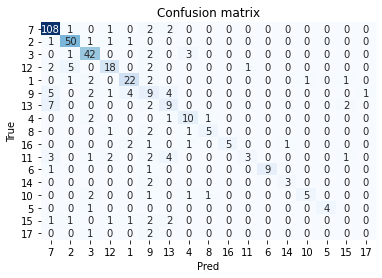

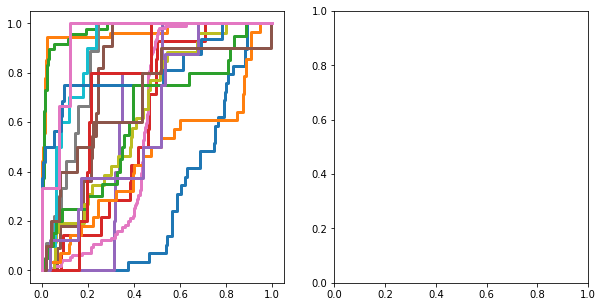

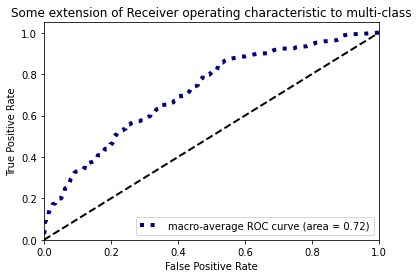

In [77]:
i = trainer.accuracies.index(max(trainer.accuracies))
trainer.getEvalOfEpoch(i)

### Ps All

#### Loading model

In [78]:
data = pd.read_csv('data/' + dataFilename)
data['SDG Goal'] = data['SDG Goal'].astype(int)
data.shape

(2729, 18)

In [79]:
trainer = ModelTrainer(data, newModel=False, n_epochs=3, test_size=test_size, modelFilename=modelPsAllFilename, target_col='five Ps')

#### Results

In [80]:
trainer.printDataValueCounts()

Labels: ['Prosperity', 'People', 'Planet', 'Peace', 'Partnerships']
X_train: 2319 samples
X_test: 410 samples


In [81]:
print(f"Avg acc = {sum(trainer.accuracies[1:])/len(trainer.accuracies[1:])}")
trainer.accuracies

Avg acc = 0.8073170731707318


[0.7975609756097561,
 0.8097560975609757,
 0.8,
 0.8048780487804879,
 0.824390243902439,
 0.8170731707317073,
 0.7829268292682927,
 0.8121951219512196,
 0.8048780487804879,
 0.8097560975609757]

Accuracy: 0.82
Auc: 0.45
Detail:
              precision    recall  f1-score   support

Partnerships       0.00      0.00      0.00         3
       Peace       0.75      0.60      0.67        10
      People       0.85      0.85      0.85       161
      Planet       0.58      0.42      0.49        33
  Prosperity       0.83      0.89      0.86       203

    accuracy                           0.82       410
   macro avg       0.60      0.55      0.57       410
weighted avg       0.81      0.82      0.82       410



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


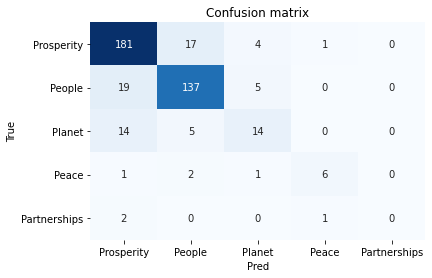

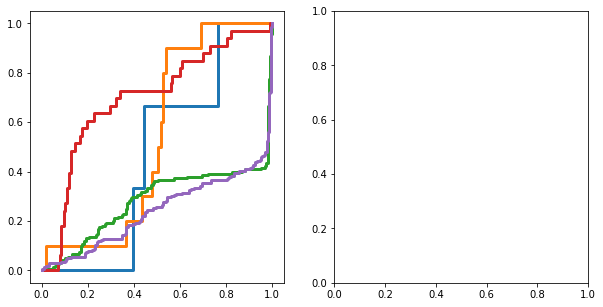

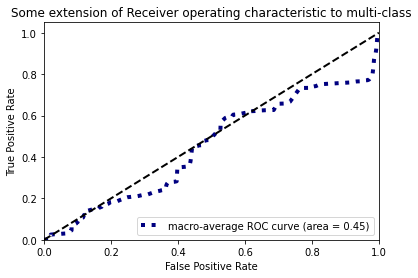

In [82]:
i = trainer.accuracies.index(max(trainer.accuracies))
trainer.getEvalOfEpoch(i)

### Goals Top

#### Loading model

In [83]:
data = pd.read_csv('data/' + dataFilename)
data['SDG Goal'] = data['SDG Goal'].astype(int)
labels = data['SDG Goal'].value_counts().index.tolist()[:7]
data = data[data['SDG Goal'].isin(labels)]
data.shape

(2119, 18)

In [84]:
trainer = ModelTrainer(data, newModel=False, n_epochs=6, test_size=test_size, modelFilename=modelSDGTopFilename)

#### Results

In [85]:
trainer.printDataValueCounts()

Labels: [7, 2, 3, 12, 1, 9, 13]
X_train: 1801 samples
X_test: 318 samples


In [86]:
print(f"Avg acc = {sum(trainer.accuracies[1:])/len(trainer.accuracies[1:])}")
trainer.accuracies

Avg acc = 0.820754716981132


[0.8113207547169812,
 0.8050314465408805,
 0.8333333333333334,
 0.8050314465408805,
 0.8301886792452831,
 0.8301886792452831]

Accuracy: 0.83
Auc: 0.67
Detail:
              precision    recall  f1-score   support

           1       0.87      0.82      0.84        33
           2       0.90      0.91      0.90        57
           3       0.85      0.87      0.86        39
           7       0.91      0.94      0.92       110
           9       0.77      0.40      0.53        25
          12       0.61      0.90      0.73        31
          13       0.65      0.48      0.55        23

    accuracy                           0.83       318
   macro avg       0.79      0.76      0.76       318
weighted avg       0.84      0.83      0.83       318



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


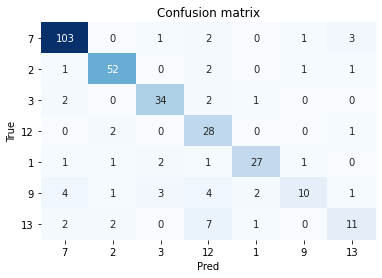

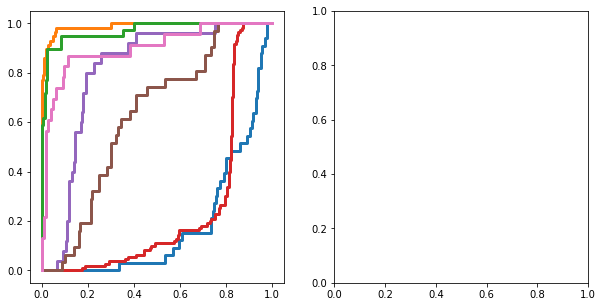

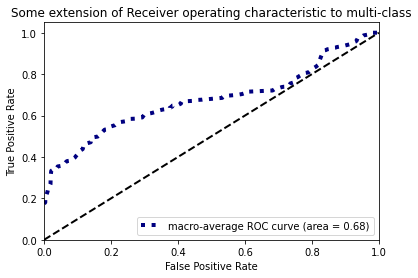

In [87]:
i = trainer.accuracies.index(max(trainer.accuracies))
trainer.getEvalOfEpoch(i)

### Ps Top

#### Loading model

In [88]:
data = pd.read_csv('data/' + dataFilename)
data['SDG Goal'] = data['SDG Goal'].astype(int)
labels = data['SDG Goal'].value_counts().index.tolist()[:7]
data = data[data['SDG Goal'].isin(labels)]
data.shape

(2119, 18)

In [89]:
trainer = ModelTrainer(data, newModel=False, n_epochs=6, test_size=test_size, modelFilename=modelPsTopFilename, target_col='five Ps')

#### Results

In [90]:
trainer.printDataValueCounts()

Labels: ['Prosperity', 'People', 'Planet']
X_train: 1801 samples
X_test: 318 samples


In [91]:
print(f"Avg acc = {sum(trainer.accuracies[1:])/len(trainer.accuracies[1:])}")
trainer.accuracies

Avg acc = 0.8754716981132076


[0.8584905660377359,
 0.8679245283018868,
 0.8805031446540881,
 0.8584905660377359,
 0.8930817610062893,
 0.8773584905660378]

Accuracy: 0.89
Auc: 0.42
Detail:
              precision    recall  f1-score   support

      People       0.90      0.93      0.91       129
      Planet       0.68      0.57      0.62        23
  Prosperity       0.92      0.91      0.91       166

    accuracy                           0.89       318
   macro avg       0.83      0.80      0.81       318
weighted avg       0.89      0.89      0.89       318



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


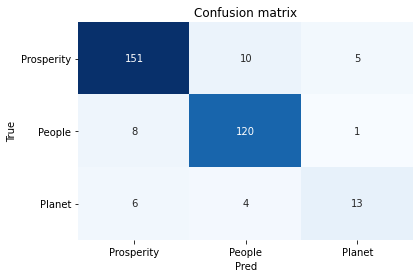

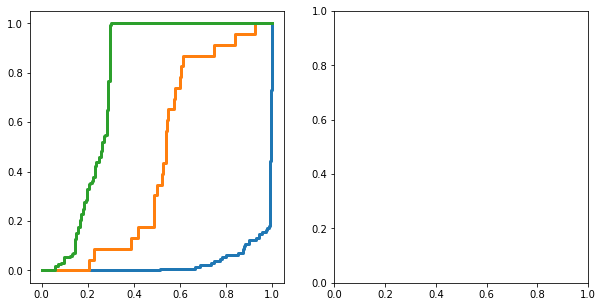

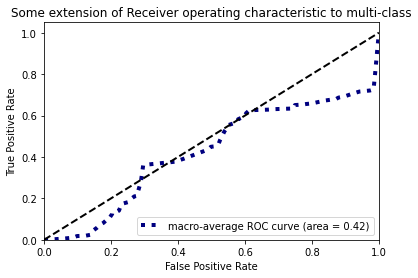

In [92]:
i = trainer.accuracies.index(max(trainer.accuracies))
trainer.getEvalOfEpoch(i)